<a href="https://colab.research.google.com/github/james-oldfield/PandA/blob/main/ffhq-edit-zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FFHQ edit zoo

Provides a quick interface to manipulate pre-annotated directions with pre-trained parts and appearances factors.

Note: these annotated directions use the global parts and thus has the implicit assumption of alignment. See `./demo.ipynb` for how to refine the global parts factors if desired.

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'PandA'
!git clone https://github.com/james-oldfield/PandA.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

fatal: destination path 'PandA' already exists and is not an empty directory.


In [2]:
# Download the pre-trained models:
!wget -r -q -np -nH --cut-dirs=2 -R *index* http://eecs.qmul.ac.uk/~jo001/PandA-pretrained-models/
!pip install tensorly==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from utils import plot_masks, plot_colours
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

from model import Model as Model
from annotated_directions import annotated_directions
model_name = "stylegan2_ffhq1024"
print(f'Available directions: {list(annotated_directions[model_name].keys())}')

Available directions: ['big_eyes', 'long_nose', 'smile', 'open_mouth', 'big_eyeballs', 'wide_nose', 'glance_left', 'glance_right', 'bald_forehead', 'light_eyebrows', 'dark_eyebrows', 'no_eyebrows', 'dark_eyes', 'red_eyes', 'eyes_short', 'eyes_open', 'eyes_close', 'no_eyes']


# Define direction of interest

In [4]:
direction = 'no_eyebrows'  # define string here from list above

Building generator for model `stylegan2_ffhq1024` ...
Finish building generator.
Loading checkpoint
Finish loading checkpoint.
-- Partial Z shape at layer 7: torch.Size([1, 512, 32, 32])


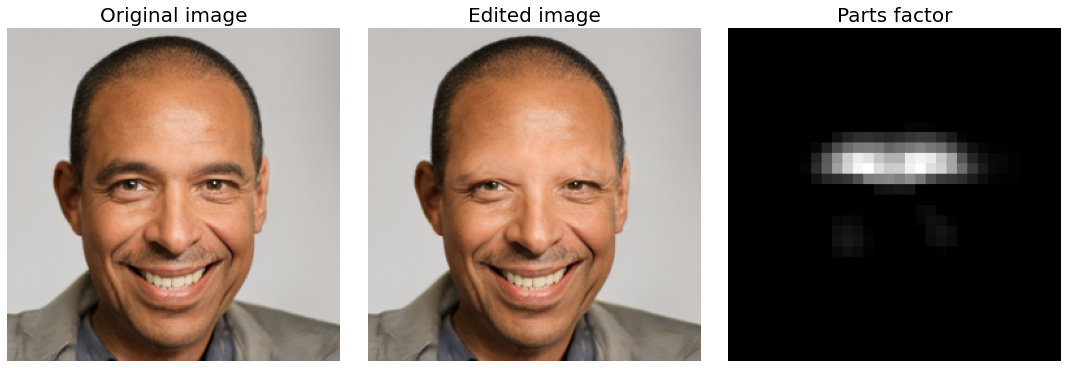

In [5]:
#################### START MODEL LOAD
layer = annotated_directions[model_name][direction]['layer']
M = Model(model_name, trunc_psi=1.0, device=device, layer=layer)
M.ranks = annotated_directions[model_name][direction]['ranks']

# load the checkpoint
try:
    model_info = annotated_directions[model_name][direction]
    M.Us = torch.Tensor(np.load(annotated_directions[model_name][direction]['checkpoints_path'][0])).to(device)
    M.Uc = torch.Tensor(np.load(annotated_directions[model_name][direction]['checkpoints_path'][1])).to(device)
except KeyError:
    raise KeyError('ERROR: No directions specified in ./annotated_directions.py for this model')
    
part, appearance, lam = annotated_directions[model_name][direction]['parameters']
#################### END MODEL LOAD

# optionally load in the codes used in the paper (else set noise=None and use t= below)
noise = torch.load('./codes/stylegan2_ffhq1024/416_z.pt', map_location=torch.device('cpu')).to(M.device)
noise = torch.load('./codes/stylegan2_ffhq1024/66_z.pt', map_location=torch.device('cpu')).to(M.device)
noise = None
t = 64
Z, image, image2, part_img = M.edit_at_layer([[part]], [appearance], [lam], t=t, Uc=M.Uc, Us=M.Us, noise=noise)

dif = np.tile(((np.mean((image-image2)**2, -1)))[:,:,None], [1,1,3]).astype(np.uint8)

# PLOT
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
ax1.imshow(image) ; ax1.set_title('Original image', fontdict={'fontsize':20}) ; ax1.axis('off')
ax2.imshow(image2) ; ax2.set_title('Edited image', fontdict={'fontsize':20}) ; ax2.axis('off')
ax3.imshow(part_img) ; ax3.set_title('Parts factor', fontdict={'fontsize':20}) ; ax3.axis('off')
plt.show()